In [1]:
import sys  
sys.path.insert(0, './../')
import numpy as np
import bbdc2021 as bbdc
import pandas as pd
from importlib import reload
reload(bbdc)
import tensorflow as tf
from keras import layers
import keras
from keras import backend as K
from itertools import groupby
import matplotlib.pyplot as plt
from matplotlib import colors 
import models.cnn.u_net_1d as unet
reload(unet)
import evaluation.evaluate as evaluate

In [2]:
np.random.seed(1)
tf.random.set_seed(1)
pathToDataset = "dataset_fft_mel_l04_o02495_f32/"

In [3]:
X_train, Y_train, timepoints, trainFileList = bbdc.load_data("train.csv", pathToDataset+"dev/")
X_validation, Y_validation, timepoints, validationFileList = bbdc.load_data("validation.csv", pathToDataset+"dev/")  
X_test, Y_test, timepoints, testFileList = bbdc.load_data("test.csv", pathToDataset+"dev/")

inputShape = X_train[0].shape

24009it [02:13, 179.64it/s]
3047it [00:16, 181.71it/s]
2988it [00:15, 187.07it/s]


In [4]:
K.image_data_format()

'channels_last'

In [4]:
X_train2 = np.expand_dims(X_train, axis=-1)
X_validation2 = np.expand_dims(X_validation, axis=-1)
X_test2 = np.expand_dims(X_test, axis=-1)
inputShape = X_train2[0].shape

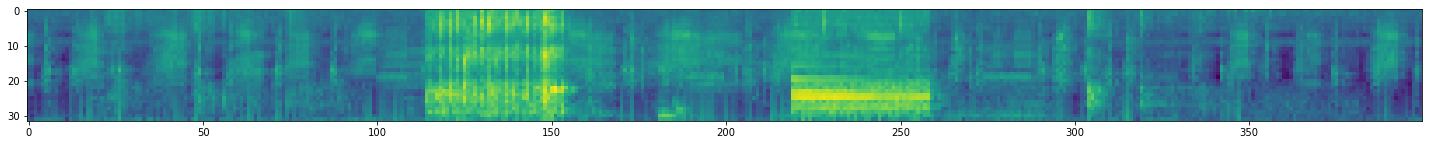

In [4]:
plt.figure(figsize=(25,5))
plt.imshow(np.rot90(X_train[0]))

In [5]:
X_challenge, _, timepoints, challengeFileList = bbdc.load_data("challenge_filelist_dummy.csv", pathToDataset+"eval/")
X_challenge = np.expand_dims(X_challenge, axis=-1)
inputShape = X_challenge[0].shape

3000it [00:47, 63.57it/s]


In [ ]:
print(tf.__version__)
print(X_train.shape)

In [6]:
def conv_bn_relu_block(x, numChannels, padding):
    x = layers.Conv2D(numChannels, kernel_size=3, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def u_net_2d(inputShape, channels, padding = "same", activation="softmax", numClasses = 13):
    if padding != "same":
        print("Gibt bisher nur Same-Padding")
        return
    input_layer = layers.Input(shape=(inputShape))
    conv_block_function = conv_bn_relu_block
    
    shortcuts = []
    x = input_layer
    #Encoder
    for numLayer in range(len(channels)-1):
        x = conv_block_function(x, channels[numLayer], padding)
        x = conv_block_function(x, channels[numLayer], padding)
        shortcuts.append(x)
        x = layers.MaxPooling2D(pool_size=(2,2))(x)
        
    x = conv_block_function(x, channels[numLayer+1], padding)
    x = conv_block_function(x, channels[numLayer+1], padding)
    
    #Decoder start
    for numLayer in reversed(range(len(channels)-1)):
        x = layers.UpSampling2D(size=(2,2))(x)
        x = layers.Concatenate()([x,shortcuts[numLayer]])
        x = conv_block_function(x, channels[numLayer], padding)
        x = conv_block_function(x, channels[numLayer], padding)
    x = layers.MaxPool2D(pool_size=(1,32))(x)
    x = layers.Conv2D(numClasses, kernel_size=1, activation=activation, padding=padding)(x)
    x = layers.Reshape((400,13))(x)

    model = keras.models.Model(inputs=input_layer, outputs=x)
    return model

In [7]:
channels = [32, 64, 90]
model = u_net_2d(inputShape, channels)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 32, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 400, 32, 32)  320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 400, 32, 32)  128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 400, 32, 32)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
#Mit crossentropy
#checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
checkpoint = keras.callbacks.ModelCheckpoint('model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
history = model.fit(X_train2,Y_train, batch_size=20, epochs=100, validation_data=(X_validation2, Y_validation), shuffle=True, callbacks=[checkpoint])

Epoch 1/100
400/400 [==============================] - 100s 173ms/step - loss: 1.3728 - mae: 0.0754 - accuracy: 0.6165 - val_loss: 1.3041 - val_mae: 0.0571 - val_accuracy: 0.6937

Epoch 00001: val_loss improved from inf to 1.30411, saving model to model.h5
Epoch 2/100
400/400 [==============================] - 69s 173ms/step - loss: 0.5200 - mae: 0.0349 - accuracy: 0.8481 - val_loss: 0.5231 - val_mae: 0.0292 - val_accuracy: 0.8523

Epoch 00002: val_loss improved from 1.30411 to 0.52307, saving model to model.h5
Epoch 3/100
400/400 [==============================] - 69s 173ms/step - loss: 0.3877 - mae: 0.0266 - accuracy: 0.8871 - val_loss: 0.3981 - val_mae: 0.0264 - val_accuracy: 0.8823

Epoch 00003: val_loss improved from 0.52307 to 0.39810, saving model to model.h5
Epoch 4/100
 61/400 [===>..........................] - ETA: 56s - loss: 0.3130 - mae: 0.0221 - accuracy: 0.9113

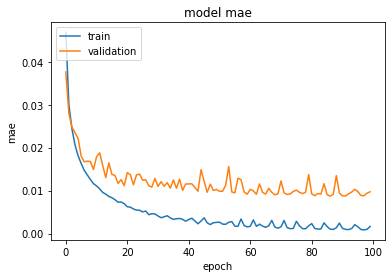

In [34]:
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

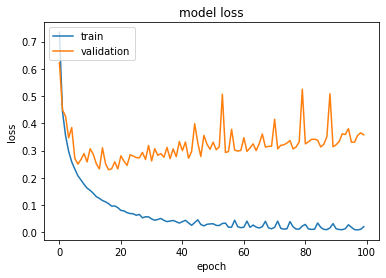

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

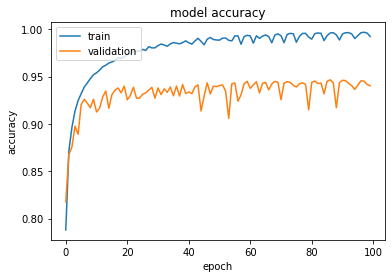

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [37]:
#model = keras.models.load_model("Modelle_Jannes/")
prediction = model.predict(X_test2)

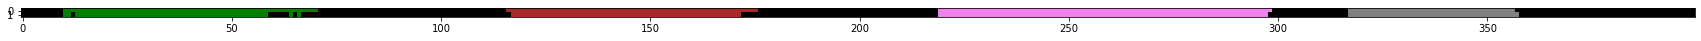

In [43]:
bbdc.plotPredictionAndGT(Y_test, prediction, 3)

In [41]:
scores = model.evaluate(X_test2, Y_test)


32/32 [==============================] - 2s 72ms/step - loss: 0.3326 - mae: 0.0093 - accuracy: 0.9429


In [44]:
df = bbdc.getPredictionAsSequenceDF(prediction, timepoints, testFileList)
df.to_csv("../predictions/jannes/Prediction2d_test.csv", index=False)
df.head()
evaluate.evaluate("../predictions/jannes/Prediction2d_test.csv", "./../data/test.csv")

(0.2723452007735842, 'Valid file')

In [45]:
postProcessedPrediction = np.array([bbdc.postProcess(pred, timepoints) for pred in prediction])
df = bbdc.getPredictionAsSequenceDF(postProcessedPrediction, timepoints, testFileList)
df.to_csv("../predictions/jannes/Prediction2d_pp_test.csv", index=False)
print(evaluate.evaluate("../predictions/jannes/Prediction2d_pp_test.csv", "./../data/test.csv"))

(0.9365476304361268, 'Valid file')


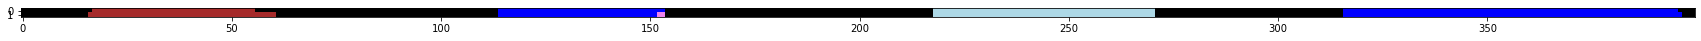

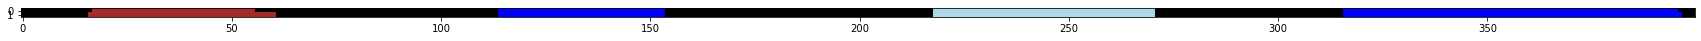

In [50]:
index = 10
bbdc.plotPredictionAndGT(Y_test, prediction, index) 
bbdc.plotPredictionAndGT(Y_test, postProcessedPrediction, index)

# Evaluation mit Validationset

In [25]:
prediction = model.predict(X_validation)
discretePrediction = (prediction == prediction.max(axis=1)[:,None]).astype(int)
model.evaluate(X_validation, Y_validation)
df = bbdc.getPredictionAsSequenceDF(prediction, timepoints, validationFileList)
df.to_csv("../predictions/jannes/LP1d_Prediction_val.csv", index=False)
print(evaluate.evaluate("../predictions/jannes/LP1d_Prediction_val.csv", "./../data/validation.csv"))

postProcessedPrediction = np.array([bbdc.postProcess(pred, timepoints) for pred in prediction])
df = bbdc.getPredictionAsSequenceDF(postProcessedPrediction, timepoints, validationFileList)
df.to_csv("../predictions/jannes/LP1d_Prediction_pp_val.csv", index=False)
print(evaluate.evaluate("../predictions/jannes/LP1d_Prediction_pp_val.csv", "./../data/validation.csv"))

32/32 [==============================] - 0s 10ms/step - loss: 0.3118 - mae: 0.0179 - accuracy: 0.9119
(0.10671975887168393, 'Valid file')
(0.8564091127358349, 'Valid file')


# Prediction der Challenge

In [53]:
#model = keras.models.load_model("Modelle_Jannes/model9561.h5")
prediction = model.predict(X_challenge)
postProcessedPredictionChallenge = np.array([bbdc.postProcess(pred, timepoints) for pred in prediction])
df = bbdc.getPredictionAsSequenceDF(postProcessedPredictionChallenge, timepoints, challengeFileList, calculateProbs=True)
df.to_csv("../predictions/jannes/2d_PredictionChallenge_mel.csv", index=False)

/home/jannes/Programme/miniconda3/envs/gpuclone/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jannes/Programme/miniconda3/envs/gpuclone/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
